In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]='-1'

In [2]:
prob_th = 0.7
iou_th = 0.5
n_anchors = 4
n_classes = 6
n_single_out = n_anchors + n_classes
net_scale = 32
grid_w, grid_h = 18, 10
input_w, input_h = grid_w*net_scale, grid_h*net_scale
anchors_w, anchors_h = 576, 320#960, 540

SCALE = 32
GRID_W, GRID_H = 18, 10
N_CLASSES = 80
N_ANCHORS = 5
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH = GRID_H*SCALE, GRID_W*SCALE, 3

In [3]:
def read_example(filename, batch_size):

    reader = tf.TFRecordReader()
    filename_queue = tf.train.string_input_producer([filename], num_epochs=None)
    _, serialized_example = reader.read(filename_queue)

    min_queue_examples = 10

    batch = tf.train.shuffle_batch([serialized_example], batch_size=batch_size, capacity=min_queue_examples+100*batch_size, min_after_dequeue=min_queue_examples, num_threads=2)

    parsed_example = tf.parse_example(batch,features={'image': tf.FixedLenFeature([], tf.string),'label': tf.FixedLenFeature([], tf.string)})

    image_raw = tf.decode_raw(parsed_example['image'], tf.uint8)
    image = tf.cast(tf.reshape(image_raw, [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH]), tf.float32)
    image = image/255.0

    label_raw = tf.decode_raw(parsed_example['label'], tf.float32)	
    label = tf.reshape(label_raw, [batch_size, GRID_H, GRID_W, N_ANCHORS, 6])

    return image, label


def read_anchors_file(file_path):

    anchors = []
    with open(file_path, 'r') as file:
        for line in file.read().splitlines():
            anchors.append(list(map(float,line.split())))

    return np.array(anchors)

def read_labels(filepath, delim):
    classes, names, colors = [], [], []
    with open(filepath,'r') as file:
        lines = file.read().splitlines()
        for line in lines:
            cls, name, color = line.split(delim)
            if int(cls) < 80:
                classes.append(int(cls)-1)
                names.append(name)
                colors.append(eval(color))

    return classes, names, colors

def iou(r1,r2):

    intersect_w = np.maximum(np.minimum(r1[0]+r1[2],r2[0]+r2[2])-np.maximum(r1[0],r2[0]),0)
    intersect_h = np.maximum(np.minimum(r1[1]+r1[3],r2[1]+r2[3])-np.maximum(r1[1],r2[1]),0)
    area_r1 = r1[2]*r1[3]
    area_r2 = r2[2]*r2[3]
    intersect = intersect_w*intersect_h	
    union = area_r1 + area_r2 - intersect

    return intersect/union

def softmax(x):

    e_x = np.exp(x)
    return e_x/np.sum(e_x)

def sigmoid(x):

    return 1.0/(1.0 + np.exp(-x))

def preprocess_data(data, anchors, a_w, a_h, important_classes):

    locations = []
    classes = []
    for i in range(grid_h):
        for j in range(grid_w):
            for k in range(n_anchors):

                class_vec = softmax(data[0, i, j, k, 5:])
                objectness = sigmoid(data[0, i, j, k, 4])
                class_prob = objectness*class_vec

                scale_w = input_w/float(a_w)
                scale_h = input_h/float(a_h)

                w = np.exp(data[0, i, j, k, 2])*anchors[k][0]*scale_w
                h = np.exp(data[0, i, j, k, 3])*anchors[k][1]*scale_h
                dx = sigmoid(data[0, i, j, k, 0])
                dy = sigmoid(data[0, i, j, k, 1])
                x = (j+dx)*net_scale-w/2.0
                y = (i+dy)*net_scale-h/2.0

                classes.append(class_prob[important_classes])
                locations.append([x, y, w, h])

    classes = np.array(classes)
    locations = np.array(locations)

    return classes, locations

def non_max_supression(classes, locations):

    classes = np.transpose(classes)
    indxs = np.argsort(-classes,axis=1)

    for i in range(classes.shape[0]):
        classes[i] = classes[i][indxs[i]]

    for class_idx, class_vec in enumerate(classes):
        for roi_idx, roi_prob in enumerate(class_vec):
            if roi_prob < prob_th:
                classes[class_idx][roi_idx]=0

    for class_idx,class_vec in enumerate(classes):
        for roi_idx, roi_prob in enumerate(class_vec):

            if roi_prob == 0:
                continue
            roi = locations[indxs[class_idx][roi_idx]]

            for roi_ref_idx, roi_ref_prob in enumerate(class_vec):

                if roi_ref_prob == 0 or roi_ref_idx <= roi_idx:
                    continue

                roi_ref = locations[indxs[class_idx][roi_ref_idx]]

                if iou(roi, roi_ref) > iou_th:
                    classes[class_idx][roi_ref_idx] = 0

    return classes, indxs


#from PIL import Image, ImageDraw, ImageFont
def draw(classes,rois, indxs, img, names, colors):

    #draw = ImageDraw.Draw(img)
    
    scale_w = img.shape[1]/float(input_w)
    scale_h = img.shape[0]/float(input_h)

    print('Drawing...')
    for class_idx, c in enumerate(classes):
        for loc_idx, class_prob in enumerate(c):
            if class_prob > 0:

                x = int(rois[indxs[class_idx][loc_idx]][0]*scale_w)
                y = int(rois[indxs[class_idx][loc_idx]][1]*scale_h)
                w = int(rois[indxs[class_idx][loc_idx]][2]*scale_w)
                h = int(rois[indxs[class_idx][loc_idx]][3]*scale_h)	

                print('Found: ', names[class_idx])
                print(' at: ', x, ', ', y)
                cv2.rectangle(img, (x, y), (x+w, y+h), colors[class_idx], 4)					
                font = cv2.FONT_HERSHEY_SIMPLEX
                text = names[class_idx] + ' %.2f'%class_prob
                cv2.putText(img, text, (x, y-8), font, 0.7, colors[class_idx], 2, cv2.LINE_AA)

    return img

INFO:tensorflow:Restoring parameters from /home/brandp/data_patrick/Data/coco/model/yolo-40000
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.NotFoundError'>, /media/patrick/WD-PBrand/coco/data.tfrecord; No such file or directory
	 [[Node: batch/ReaderReadV2 = ReaderReadV2[_device="/job:localhost/replica:0/task:0/device:CPU:0"](batch/TFRecordReaderV2, batch/input_producer)]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[2.0162545e-02 3.1927084e-03 2.5852147e-01 2.1857880e-01 4.9000000e+01
  1.0000000e+00]]
at:  0 ,  0  w:  0  h:  0


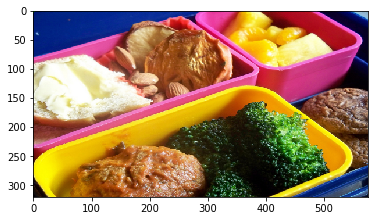

NotFoundError: /media/patrick/WD-PBrand/coco/data.tfrecord; No such file or directory
	 [[Node: batch/ReaderReadV2 = ReaderReadV2[_device="/job:localhost/replica:0/task:0/device:CPU:0"](batch/TFRecordReaderV2, batch/input_producer)]]

In [14]:


TFRECORD_PATH = '/home/brandp/data_patrick/Data/coco/data.tfrecord'
BATCH_SIZE = 1
delim=';'

important_classes, names, colors = read_labels('./80_labels.txt', delim)
anchors = read_anchors_file('/home/brandp/data_patrick/Data/coco/coco_anchors.txt')

batch_image, batch_label=read_example(TFRECORD_PATH, BATCH_SIZE)

init_op =tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('/home/brandp/data_patrick/Data/coco/model/yolo-40000.meta')
    saver.restore(sess,'/home/brandp/data_patrick/Data/coco/model/yolo-40000')
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    graph = tf.get_default_graph()
    image = graph.get_tensor_by_name("image_placeholder:0")
    train_flag = graph.get_tensor_by_name("flag_placeholder:0")
    y = graph.get_tensor_by_name("net/y:0")
    
    for i in range(1):
        image_data,label_data = sess.run([batch_image, batch_label])

        #cap = cv2.VideoCapture('./video.MP4')
        #
        #while(cap.isOpened()):
        #
        #    ret, img = cap.read()
        #    if ret is not True:
        #        break
        #
        #    img_for_net = cv2.resize(img,(input_w,input_h))
        #    img_for_net = img_for_net/255.0
        data = sess.run(y, feed_dict = {image: image_data, train_flag: False})  
        img = image_data[0]
        classes,rois = preprocess_data(data, anchors, anchors_w, anchors_h, important_classes)
        classes,indxs = non_max_supression(classes, rois)

        ind = label_data[...,5] == 1.
        print(label_data[ind])
        scale_w = img.shape[1]/float(input_w)
        scale_h = img.shape[0]/float(input_h)
        x = int(label_data[ind][...,0]*scale_w)
        y = int(label_data[ind][...,1]*scale_h)
        w = int(label_data[ind][...,2]*scale_w)
        h = int(label_data[ind][...,3]*scale_h)	

        #print('Found: ', names[class_idx])
        print('at: ', x, ', ', y, ' w: ', w, ' h: ', h)
        cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 4)
        font = cv2.FONT_HERSHEY_SIMPLEX
        #text = names[class_idx] + ' %.2f'%class_prob
        #cv2.putText(img, text, (x, y-8), font, 0.7, colors[class_idx], 2, cv2.LINE_AA)
        #print(label_data)
        #print(data.shape)
        
        #img = draw(classes, rois, indxs, img, names, colors)
        #
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # as opencv loads in BGR format by default, we want to show it in RGB.
        plt.show()
        #cv2.moveWindow('img', 0, 0)
        #    key = cv2.waitKey()
        #    if key == 27: break

    coord.request_stop()
    coord.join(threads)

In [ ]:
import sys, getopt
import json
 
json_file = '/home/brandp/data_patrick/Data/coco/annotations/instances_train2014.json'

with open(json_file,'r') as COCO:
    js = json.loads(COCO.read())
    #c = json.dumps(js['categories'], sort_keys=True)[0]
    c = js['categories']

In [ ]:
import csv
color = (0,255,0)
delim = ';'
#with open('80_labels.txt', 'w') as out:
#    writer = csv.writer(out, delimiter=delim)
for instance in c:
    ID = str(instance['id'])
    NAME = str(instance['name'])
    row = [ID, NAME, color]
    #writer.writerow(row)
    print('{}{}{}{}{}'.format(ID,delim, NAME,delim, color))

In [ ]:

classes, names, colors = [], [], []
with open('./80_labels.txt','r') as file:
    lines = file.read().splitlines()
    for line in lines:
        cls, name, color = line.split(delim)
        classes.append(int(cls))
        names.append(name)
        colors.append(eval(color))


In [ ]:
print(colors)